# Credit Scoring Project - WOE Binning & Modeling
This notebook performs EDA, WOE binning, IV calculation, and initial model training for the credit scoring system.

In [25]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [26]:
# 📥 Load Data
df = pd.read_csv('../data/cs-training.csv', index_col=0)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Step 1: Data Cleaning

In [27]:
# Handle missing values
df.fillna(-999, inplace=True)
df['SeriousDlqin2yrs'].value_counts(normalize=True)

SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64

## Step 2: WOE Binning + IV Calculation

In [28]:
# WOE Binning
bins = sc.woebin(df, y='SeriousDlqin2yrs')
woe_df = sc.woebin_ply(df, bins)
woe_df.head()

[INFO] creating woe binning ...


/Users/yahuanshi/.pyenv/versions/3.12.4/lib/python3.12/site-packages/scorecardpy/germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/yahuanshi/.pyenv/versions/3.12.4/lib/python3.12/site-packages/scorecardpy/germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/yahuanshi/.pyenv/versions/3.12.4/lib/python3.12/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observ

[INFO] converting into woe values ...


/Users/yahuanshi/.pyenv/versions/3.12.4/lib/python3.12/site-packages/scorecardpy/germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/yahuanshi/.pyenv/versions/3.12.4/lib/python3.12/site-packages/scorecardpy/germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


,SeriousDlqin2yrs,NumberRealEstateLoansOrLines_woe,NumberOfTime60-89DaysPastDueNotWorse_woe,RevolvingUtilizationOfUnsecuredLines_woe,MonthlyIncome_woe,NumberOfTimes90DaysLate_woe,DebtRatio_woe,NumberOfDependents_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTime30-59DaysPastDueNotWorse_woe,age_woe
1,1,0.253629,-0.288208,0.578018,-0.225690,-0.389724,0.630507,0.209307,-0.128983,1.901126,0.100377
2,0,0.235970,-0.288208,1.355364,0.426350,-0.389724,-0.135931,0.102578,-0.128983,-0.541721,0.449516
3,0,0.235970,-0.288208,0.578018,0.426350,2.298734,-0.135931,-0.150060,0.727837,0.903654,0.449516
4,0,0.235970,-0.288208,-0.407030,0.426350,-0.389724,-0.135931,-0.150060,-0.128983,-0.541721,0.449516
5,0,-0.256641,-0.288208,1.355364,-0.459905,-0.389724,-0.135931,-0.150060,-0.128983,0.903654,0.100377


In [29]:
# Show IV values

iv_list = []
for var in bins:
    iv_val = bins[var]['total_iv'].values[0]
    iv_list.append({'variable': var, 'info_value': iv_val})
iv_df = pd.DataFrame(iv_list)
iv_df.sort_values(by='info_value', ascending=False)


,variable,info_value
2,RevolvingUtilizationOfUnsecuredLines,1.073162
4,NumberOfTimes90DaysLate,0.837551
8,NumberOfTime30-59DaysPastDueNotWorse,0.740481
1,NumberOfTime60-89DaysPastDueNotWorse,0.572373
9,age,0.246913
3,MonthlyIncome,0.083398
7,NumberOfOpenCreditLinesAndLoans,0.075373
5,DebtRatio,0.070047
0,NumberRealEstateLoansOrLines,0.055354
6,NumberOfDependents,0.033818


## Step 3: Modeling (Logistic Regression & XGBoost)

In [30]:
# Prepare data
X = woe_df.drop(columns='SeriousDlqin2yrs')
y = woe_df['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]
print('Logistic AUC:', roc_auc_score(y_test, lr_pred))

Logistic AUC: 0.8576313212947494


In [31]:
# XGBoost Classifier
from xgboost import XGBClassifier

# initialize XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict_proba(X_test)[:, 1]
print("XGBoost AUC:", roc_auc_score(y_test, xgb_pred))

XGBoost AUC: 0.8526706282403074


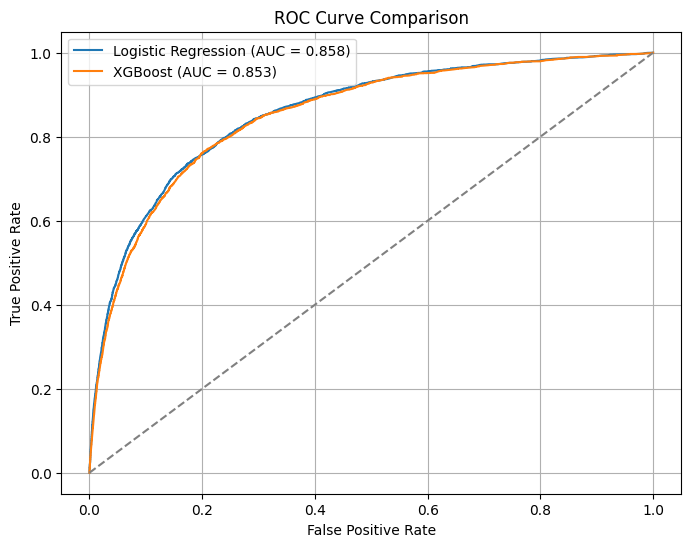

In [32]:
# ROC Curve Comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, lr_pred):.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_pred):.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Map probability to score
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd()))
if os.path.isdir(os.path.join(project_root, "src")):
    sys.path.append(project_root)
sys.path.append(os.path.abspath(".."))

    
from src.scorecard_utils import prob_to_score


lr_scores  = prob_to_score(lr_pred)
xgb_scores = prob_to_score(xgb_pred)

score_df = pd.DataFrame({
    "True_Label": y_test.values,
    "LR_Score": lr_scores,
    "XGB_Score": xgb_scores
})
score_df.head()


,True_Label,LR_Score,XGB_Score
0,0,77.952249,20.966059
1,0,79.204999,30.119802
2,0,89.153991,53.197981
3,0,228.047236,217.686282
4,0,190.524688,170.084717


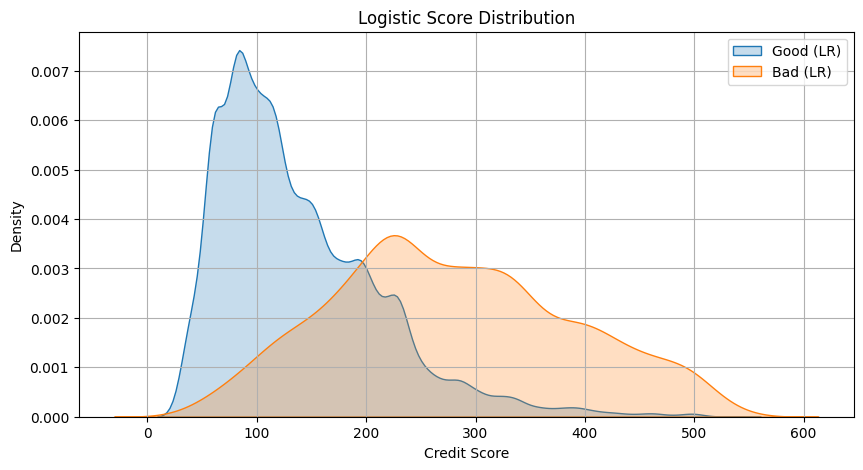

In [38]:
# Score distribution plot
plt.figure(figsize=(10,5))
sns.kdeplot(score_df[score_df['True_Label']==0]['LR_Score'], label='Good (LR)', fill=True)
sns.kdeplot(score_df[score_df['True_Label']==1]['LR_Score'], label='Bad (LR)', fill=True)
plt.title('Logistic Score Distribution')
plt.xlabel('Credit Score')
plt.legend(); plt.grid(True)

In [47]:
import os
os.chdir("..")

from src.scorecard_utils import prob_to_score, save_model, load_model
save_model(lr, "models/logistic_model.pkl")
